<a href="https://colab.research.google.com/github/KingJulien0709/RowingAnalytics/blob/main/rowing_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -r requirements.txt
#from google.colab import drive    only for colab 
#drive.mount('/content/drive') 
from ultralytics import YOLO



Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement google-colab (from versions: none)

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: c:\program files\python38\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for google-colab


In [8]:
import json

def load_class_labels():
    class_labels = {}
    with open("class_labels.json", "r") as f:
        class_labels = json.load(f)
    return class_labels["class_labels"]

class_labels = load_class_labels()
#print(class_labels)

def get_improvement_for_error_class(class_id):
    return class_labels[class_id].get("improvement")

def get_error_description_for_error_class(class_id):
    return class_labels[class_id].get("description")
 

print(get_improvement_for_error_class(1))
print(get_error_description_for_error_class(1))


Wait until the legs have been pushed completely, then pull with upper body.
During the drive the back/upper body is being opened too early.


In [3]:
#video_path= "/content/drive/My Drive/ergo_berg.mp4" 
video_path= "C:\\Users\\kinde\\Downloads\\ergo_berg.mp4" 
model = YOLO("yolo12n.pt")
model = YOLO("models\\yolo11n-pose.pt")

AttributeError: Can't get attribute 'A2C2f' on <module 'ultralytics.nn.modules.block' from 'c:\\Users\\kinde\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\ultralytics\\nn\\modules\\block.py'>

In [3]:
#video_path = "/content/drive/My Drive/ergo_short2_small.mp4"
#"/content/drive/My Drive/video_row2.mp4"
import src.video_processing as vp

result, frame_rate = vp.predict_poses(video_path, model, save_video=False)
print(result[0].keypoints)



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/431) C:\Users\kinde\Downloads\ergo_berg.mp4: 192x320 1 person, 155.0ms
video 1/1 (frame 2/431) C:\Users\kinde\Downloads\ergo_berg.mp4: 192x320 1 person, 111.4ms
video 1/1 (frame 3/431) C:\Users\kinde\Downloads\ergo_berg.mp4: 192x320 1 person, 130.3ms
video 1/1 (frame 4/431) C:\Users\kinde\Downloads\ergo_berg.mp4: 192x320 1 person, 73.6ms
video 1/1 (frame 5/431) C:\Users\kinde\Downloads\ergo_berg.mp4: 192x320 1 person, 75.4ms
video 1/1 

In [39]:
#print(result[0].keypoints)
#print(result[0].boxes)

In [ ]:
import src.video_processing as vp
import src.joint_heatmap_preprocessing as jhp
import matplotlib.pyplot as plt
import numpy as np
import src.stroke_processing as sp
import src.utils as utils
import json
import yaml

keypoints = vp.get_relevant_normalized_keyframes(results=result, selected_joints=[],frame_rate=frame_rate, all=True, clean_numbers=True)

strokes = sp.segment_strokes(keypoints,frame_rate,right=True) #video was recorded from the right side


def processing_keypoints(keypoints):
    time_sampled_keypoints = jhp.uniform_sample_from_frames(keypoints, 48)
    resized_keypoints = time_sampled_keypoints * [56, 56, 1]  #scale keypoints to 56x56 image and keep the confidence values
    j_hp = jhp.create_gaussian_joint_map_optimized(resized_keypoints, 56, 56, 0.5)
    roi = jhp.calculate_roi(resized_keypoints,2)
    zoomed_map = jhp.zoom_to_roi(j_hp, roi)
    return zoomed_map


def read_training_video(video_path):#json_file with the training videos under the key "videos"
    videos = []
    with open("training_videos.json", "r") as f:
        training_videos = json.load(f)["videos"]
    for video in training_videos:
        path = video["path"]
        class_id = video["id"]
        videos.append((path, class_id))
    return videos
    
videos = read_training_video("training_videos.json")

def get_all_keypoint_estimations(videos):
    model = YOLO("models\\yolo11n-pose.pt")
    all_keypoints = []
    for video in videos:
        result, frame_rate = vp.predict_poses(video[0], model, save_video=False)
        keypoints = vp.get_relevant_normalized_keyframes(results=result, selected_joints=[],frame_rate=frame_rate, all=True, clean_numbers=True)
        all_keypoints.append((keypoints, frame_rate, video[1],))
    return all_keypoints

all_keypoints = get_all_keypoint_estimations(videos)
utils.save_obj(all_keypoints, "all_keypoints")

def analyze_strokes_from_sequence(sequence, frame_rate):
    strokes = sp.segment_strokes(keypoints,frame_rate,right=True)
    for stroke in strokes:
        zoomed_map = processing_keypoints(stroke)
        #predict stroke class and a similarity score
        predict_class = 0 #dummy
        feedback = (get_error_description_for_error_class(predict_class), get_improvement_for_error_class(predict_class))
        print(feedback)


def train_model(videos):
    all_keypoints = utils.load_obj("all_keypoints")
    for keypoints, frame_rate, class_id in all_keypoints:
        for keypoint in keypoints:
            analyze_strokes_from_sequence(keypoint, frame_rate)
            #train model with the feedback
            #save model
            #evaluate model
            #save evaluation
            #save training data
            #save training results
            #save training logs
            


    



tensor(2)
5


In [ ]:
import src.visualizing as vis

zoomed_map = processing_keypoints(keypoints)
vis.image_to_video(zoomed_map, "C:\\Users\\kinde\\Downloads\\test.avi",frame_rate=frame_rate)

(17, 56, 56)


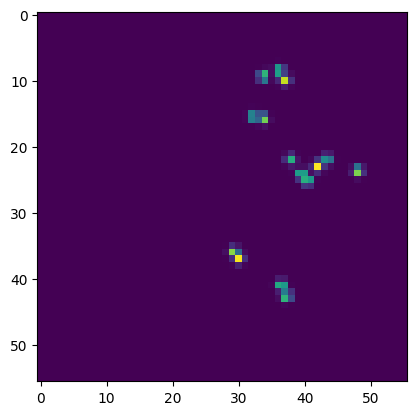

In [42]:
import matplotlib.pyplot as plt
import numpy as np

max_map = np.max(j_hp[9], axis=0)
plt.imshow(max_map.T)
plt.show()

In [8]:
import src.video_processing as vp


res = vp.get_relevant_normalized_keyframes(result[0:5], frame_rate, [6, 8, 10, 12, 14, 16])
print(res)

tensor([[[0.5291, 0.2846, 0.9860],
         [0.6642, 0.4132, 0.9786],
         [0.7842, 0.4206, 0.9711],
         [0.5018, 0.6405, 0.9790],
         [0.6726, 0.5074, 0.9712],
         [0.6719, 0.7884, 0.9275]],

        [[0.5165, 0.2893, 0.9854],
         [0.6497, 0.4160, 0.9777],
         [0.7701, 0.4143, 0.9706],
         [0.4982, 0.6454, 0.9769],
         [0.6635, 0.5048, 0.9680],
         [0.6719, 0.7869, 0.9187]],

        [[0.5116, 0.2921, 0.9860],
         [0.6418, 0.4172, 0.9785],
         [0.7682, 0.4119, 0.9704],
         [0.4975, 0.6476, 0.9777],
         [0.6627, 0.5064, 0.9672],
         [0.6769, 0.7905, 0.9141]],

        [[0.5062, 0.2896, 0.9905],
         [0.6422, 0.4094, 0.9839],
         [0.7559, 0.4049, 0.9742],
         [0.4941, 0.6581, 0.9828],
         [0.6649, 0.4985, 0.9739],
         [0.6736, 0.7830, 0.9310]],

        [[0.4915, 0.2884, 0.9891],
         [0.6251, 0.4218, 0.9774],
         [0.7487, 0.4195, 0.9674],
         [0.4801, 0.6526, 0.9840],
         [0.

In [9]:
import torch
import matplotlib.pyplot as plt

def get_relevant_normalized_keyframes(results, frame_rate, selected_joints, remove_wrong_numbers=False, all=False):
  normalized_keyframes_tensor = [(result.keypoints.xyn, result.keypoints.conf) for result in results]
  conf_score = [result.keypoints.conf for result in results]
  #key_point = (x,y,c)
  if all:
    selected_joints_keyframes = torch.stack(normalized_keyframes_tensor)
  else:
    selected_joints_keyframes = torch.stack([n_k_t.squeeze(0)[selected_joints] for n_k_t in normalized_keyframes_tensor])
  if remove_wrong_numbers:
    error_values = torch.any(selected_joints_keyframes[:, :,0:2]==0, dim=(1,2))
    selected_joints_keyframes = selected_joints_keyframes[~error_values]
  return selected_joints_keyframes

body_parts = {
    0: "Nose",
    1: "Left Eye",
    2: "Right Eye",
    3: "Left Ear",
    4: "Right Ear",
    5: "Left Shoulder",
    6: "Right Shoulder",
    7: "Left Elbow",
    8: "Right Elbow",
    9: "Left Wrist",
    10: "Right Wrist",
    11: "Left Hip",
    12: "Right Hip",
    13: "Left Knee",
    14: "Right Knee",
    15: "Left Ankle",
    16: "Right Ankle"
}
print(len(result))
result_copy = []



normalized_keyframes_tensor = [result[0].keypoints.xyn for result in result]
selcted_joints = [6, 8, 10, 12, 14, 16]

#print(normalized_keyframes_tensor[:][0].shape)

#keyframe = normalized_keyframes_tensor[0]#.squeeze(0)
#print(keyframe.shape)
#selected_joints_keyframe = keyframe[selcted_joints]




selected_joints_keyframes = torch.stack([n_k_t.squeeze(0)[selcted_joints] for n_k_t in normalized_keyframes_tensor])
error_values = torch.any(selected_joints_keyframes[:, :,0:2]==0, dim=(1,2))
filtered_keyframes = selected_joints_keyframes[~error_values]
#selected_joints_keyframes[error_values] =
print(filtered_keyframes.shape)

print(selected_joints_keyframes.shape)


#plot the trajectories
print(filtered_keyframes[:,0,1])
trajectories = { body_parts[selcted_joints[i]]: (filtered_keyframes[:,i,0], filtered_keyframes[:,i,1]) for i in range(len(selcted_joints))}

#trajectories = {
#    "joint_0": (filtered_keyframes[:,0,0], filtered_keyframes[:,0,1]),
#    "joint_1": (filtered_keyframes[:,1,0], filtered_keyframes[:,1,1]),
#    "joint_2": (filtered_keyframes[:,2,0], filtered_keyframes[:,2,1]),
 #   "joint_8": (filtered_keyframes[:,3,0], filtered_keyframes[:,3,1]),
#}


plt.figure(figsize=(10, 8))
for label, (x, y) in trajectories.items():
    plt.plot(x.cpu(), 1-y.cpu(), marker='o', label=label)

# Customizing the plot
plt.title("Multiple 2D Trajectories")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(True)
plt.legend()  # Add legend to distinguish paths
plt.show()

431


TypeError: any() received an invalid combination of arguments - got (Tensor, dim=tuple), but expected one of:
 * (Tensor input)
 * (Tensor input, int dim, bool keepdim, *, Tensor out)
 * (Tensor input, name dim, bool keepdim, *, Tensor out)


In [ ]:
#calculate distances between keypoints
from scipy.signal import savgol_filter
import src.stroke_processing as sp


selected_angle_pairs = torch.tensor([
    [[4, 5],[4, 3]], #knee angle
    [[3,2],[3,4]], #hip angle
    [[1,2],[1,0]], #arm angle
    [[2,1],[2,3]], #shoulder angle
])



timestep = 31
anglepair = 0
#v1_single_v = filtered_keyframes[:, selected_angle_pairs[anglepair, 0, 0]] - filtered_keyframes[:, selected_angle_pairs[anglepair, 0, 1]]
#v2_single_v = filtered_keyframes[:, selected_angle_pairs[anglepair, 1, 0]] - filtered_keyframes[:, selected_angle_pairs[anglepair, 1, 1]]
#angles = torch.acos(torch.sum(v1_single_v * v2_single_v, dim=1) / (torch.norm(v1_single_v, dim=1) * torch.norm(v2_single_v, dim=1)))*180/3.14
#angles =

angles_knee = sp.calculate_angles_for_joint(filtered_keyframes, selected_angle_pairs[0])
angles_hip = sp.calculate_angles_for_joint(filtered_keyframes, selected_angle_pairs[1])
angles_arm = sp.calculate_angles_for_joint(filtered_keyframes, selected_angle_pairs[2])
angles_shoulder = sp.calculate_angles_for_joint(filtered_keyframes, selected_angle_pairs[3])

window_length = frame_rate // 5 #for consistent smoothing adjust the windowlenght to the framerate
smoothed_angles_knee = savgol_filter(angles_knee.cpu().numpy(), window_length=window_length, polyorder=1)
smoothed_angles_hip = savgol_filter(angles_hip.cpu().numpy(), window_length=window_length, polyorder=1)
smoothed_angles_arm = savgol_filter(angles_arm.cpu().numpy(), window_length=window_length, polyorder=1)
smoothed_angles_shoulder = savgol_filter(angles_shoulder.cpu().numpy(), window_length=window_length*3, polyorder=1)

plt.figure(figsize=(10, 8))
plt.plot(smoothed_angles_knee)
plt.plot(smoothed_angles_hip)
plt.plot(180-smoothed_angles_arm) #show "reversed" angle to allign for phase analysis
plt.plot(smoothed_angles_shoulder)
#plt.plot(angles_arm.cpu())
#plt.plot(angles_shoulder.cpu())
plt.legend(["knee", "hip", "arm" ,"shoulder"])
plt.show() #sharp peakes in the plot show the removed values/values beeing out of the camera view -> interpolate should be better than complety removing.

#print(angles_hip)


#print(v1_single_v.shape)
#print(v2_single_v.shape)

#distance = torch.cdist(filtered_keyframes, filtered_keyframes)
#print(distance.shape)
#distances = [distance for

In [ ]:
import numpy as np



In [ ]:
#divide in single strokes
from scipy.signal import find_peaks
import numpy as np
import src.visualizing as vis

##find local minima and maxima, use only minima
min_peaks = sp.extract_stroke_sequences_gradient(smoothed_angles_knee)

##divide into single strokes
strokes = []

#print(min_peaks)
for i in range(len(min_peaks)-1):
  smoothed_angles_knee_slice = smoothed_angles_knee[min_peaks[i]:min_peaks[i+1]]
  smoothed_angles_hip_slice = smoothed_angles_hip[min_peaks[i]:min_peaks[i+1]]
  smoothed_angles_arm_slice = 180-smoothed_angles_arm[min_peaks[i]:min_peaks[i+1]] #invert arm agle for better visulisation
  #smoothed_angles_shoulder_slice = smoothed_angles_shoulder[min_peaks[i]:min_peaks[i+1]]
  strokes.append([smoothed_angles_knee_slice, smoothed_angles_hip_slice, smoothed_angles_arm_slice])#, smoothed_angles_shoulder_slice])
print(len(strokes))


#plot_single_stroke(strokes[2], ["knee", "hip", "arm"], normalize=True)
for stroke in strokes:
  vis.plot_single_stroke(stroke.copy(), ["knee", "hip", "arm"], normalize=False,derivativ=True)

In [ ]:
##analyse stroke
#basic timing analysis with first order derivativ maxima and minima
def analyse_stroke(stroke,use_derivativ=True):
  stroke_absolut_length = len(stroke[0])
  stroke_duration = float(stroke_absolut_length/frame_rate)
  #print(stroke_duration)
  stroke_rate = round(60/stroke_duration)
  #print(stroke_rate)
  dx_angles = np.diff(stroke.copy())
  if use_derivativ:
    dx_angles = np.diff(savgol_filter(stroke.copy(), window_length=frame_rate//3, polyorder=1))
  #print(dx_angles.shape)
  maxima = np.argmax(dx_angles, axis=1)/(stroke_absolut_length/2)
  minima = np.argmin(dx_angles, axis=1)/(stroke_absolut_length/2)
  #print(np.diff(maxima))
  #print(np.diff(minima))
  timing_ditances = [np.diff(maxima), np.diff(minima)]
  #print(timing_ditances)

  return timing_ditances

  #for i in range(len(dx_angles)):
  #  plt.plot(dx_angles[i])
  #plt.plot(maxima)
  #plt.plot(minima)
  #plt.show()
  #print(maxima)

  #distances = np.diff(maxima)
  #print(distances)





plt.figure(figsize=(10, 8))
plt.xlabel("knee-hip distance")
plt.ylabel("knee-arm distance")
for i in range(len(strokes)):
  timings = analyse_stroke(strokes[i])
  x_coords, y_coords = zip(*timings)
  plt.scatter(x_coords, y_coords, marker='o', label=str(i))
  #plt.scatter(x_coords[1], y_coords[1], marker='o', label="minima" + str(i))

plt.legend()
plt.show()


In [ ]:
# keypoint as form of K * (x,y,c)
def create_joint_heatmaps(keypoints):
  x,y,c = keypoints[0]
  j_map_k = torch.


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt


KEY_POINTS = 17
LIMB_SEQ = [
    # Head and Neck
    [0, 5],  # Nase → Linke Schulter
    [0, 6],  # Nase → Rechte Schulter

    # Upper Body
    [5, 7],  # Linke Schulter → Linker Ellenbogen
    [7, 9],  # Linker Ellenbogen → Linkes Handgelenk
    [6, 8],  # Rechte Schulter → Rechter Ellenbogen
    [8, 10], # Rechter Ellenbogen → Rechtes Handgelenk

    # Torso
    [5, 11], # Linke Schulter → Linke Hüfte
    [6, 12], # Rechte Schulter → Rechte Hüfte
    [11, 12],# Linke Hüfte → Rechte Hüfte (Spine)

    # Lower Body
    [11, 13],# Linke Hüfte → Linkes Knie
    [13, 15],# Linkes Knie → Linkes Fußgelenk
    [12, 14],# Rechte Hüfte → Rechtes Kniegelenk
    [14, 16],# Rechtes Kniegelenk → Rechter Knöchel

    # Optional Head Details
    [0, 1],  # Nase → Linkes Auge
    [0, 2],  # Nase → Rechtes Auge
    [1, 3],  # Linkes Auge → Linkes Ohr
    [2, 4]   # Rechtes Auge → Rechtes Ohr
]





#demo_keypoints = create_demo_keypoints(KEY_POINTS, 56, 56)
#l_map = create_gaussian_limb_map(demo_keypoints, 56, 56, LIMB_SEQ, std=0.5)
#j_map = create_gaussian_joint_map(demo_keypoints, 56, 56, std=1)
#print(j_map.shape)
#plt.imshow(create_max_pooling_map(j_map))
#plt.show()
#plt.imshow(create_max_pooling_map(l_map))
#plt.show()


In [ ]:
T=48

def pipeline(stroke, classical=False, segmented = False):
  results, framerate = predict_poses(stroke.path)
  if classical:
    keypoints = get_relevant_normalized_keyframes(results=results, framerate=framerate, keypoints=["knee", "hip", "arm"])
    angles = get_angles(keypoints)##calculate angles for pairs not the actual function here
    strokes = [stroke]
    if not segmented:
      stroke = [_ for s  in segemneted_strokes(stroke)] #implement but have to be selected
      print("not implemented yet, have to segment stroke sequence into single strokes")
      #add to list
    print("not implemented yet, can directly interpret stroke or array of strokes")
    timing = [analyse_stroke(stroke) for stroke in strokes]

    ## compare to other strokes timing with dtw and knn
    feedback = [analyse_stroke(stroke) for stroke in strokes]
    return feedback
  else:
    #1. segment if not segmented
    if not segmented:
      return None
    keypoints = get_relevant_normalized_keyframes(results=results, framerate=framerate, keypoints=[],all=True)
    #2. sample t to T (time dimension) first for faster computation, compared to original paper
    keypoints = uniform_sample_from_frames(keypoints, T)
    #3. cast to probabalistic framework by gaussians and scale to 0,55 for H and W, only for joints, limps are computational too expensive
    kexpoints = keypoints * [56, 56, 1]
    j_map, roi = create_gaussian_joint_map(keypoints, 56, 56, std=1)
    #4. zoom_crop to ROI
    zoomed_j_map = zoom_to_roi(j_map, roi)
    print(zoomed_j_map)

    #put into 3dpose cnn
    #feedback = class (with score by distance to positive class)
    #feedback = calculate_feedback(disimilarity, class_vector)


